### Zustandsschätzung auf Basis von Sensordaten

In [1]:
#Python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Parameter-File
import personal_params as p

#Eigene UKF und Gleichungsfunktionen
from Test_UKF_pyUKF import UKF, UKFException #pyUKF-Klasse
from Test_UKF_ode_Dt_sim import f_odes_Dt_sim #Gleichungsfunktion, Rückgabe: 4 Zustände, k1, k5, taug auf Literaturwert gesetzt
from ukf_pred_upd_2 import pred_upd_2 #Prediction/Update Schritte des UKFs, auf Sensordaten-Inputs getrimmt

#Schätzfehler
from estimate_error import estimate_error
from estimate_error_2 import estimate_error_2
from mask_data import mask_data

#Plotten der UKF Zustandsschätzungen
from plot_ukf import plot_ukf
from plot_ukf_2 import plot_ukf_2

In [2]:
data = pd.read_csv("sensordata/clean_data.csv", sep = ",", parse_dates = ["timestamp"])

In [3]:
data.head()

,timestamp,event,event2,gluc_mmol_L,kh_g,Dauer (hh:mm:ss),delta_time_s
0,2025-12-04 19:51:28,EGV,NaN,4.7,NaN,NaN,71488.0
1,2025-12-04 19:56:27,EGV,NaN,5.2,NaN,NaN,71787.0
2,2025-12-04 20:01:28,EGV,NaN,5.2,NaN,NaN,72088.0
3,2025-12-04 20:06:28,EGV,NaN,4.8,NaN,NaN,72388.0
4,2025-12-04 20:11:28,EGV,NaN,4.9,NaN,NaN,72688.0


In [4]:
data.columns

Index(['timestamp', 'event', 'event2', 'gluc_mmol_L', 'kh_g',
       'Dauer (hh:mm:ss)', 'delta_time_s'],
      dtype='object')

In [5]:
data["timestamp"].iloc[0].date()

datetime.date(2025, 12, 4)

In [6]:
weekdays= "Montag", "Dienstag", "Mittwoch", "Donnerstag", "Freitag", "Samstag", "Sonntag", 
days_count = [0,0,0,0,0,0,0]

days = {}

current_day = data["timestamp"].iloc[0].date()
days[weekdays[current_day.weekday()]+"_"+str(days_count[current_day.weekday()])] = []

for i, date in enumerate(data["timestamp"]):
    if date.date() != current_day: #Falls neues Datum
        current_day = date.date()
        days_count[date.dayofweek]+=1
        days[weekdays[date.dayofweek]+"_"+str(days_count[date.dayofweek])] = [] #neuen Dictionary-key erstellen
        days[weekdays[date.dayofweek]+"_"+str(days_count[date.dayofweek])].append(i) #Indize der Zeilen in data speichern

    else:
        days[weekdays[date.dayofweek]+"_"+str(days_count[date.dayofweek])].append(i) #Indize der Zeilen in data speichern

In [7]:
for key in days:
    print(key)

Donnerstag_0
Freitag_1
Samstag_1
Sonntag_1
Montag_1
Dienstag_1
Mittwoch_1
Donnerstag_1
Freitag_2
Samstag_2
Sonntag_2


### Daten zu Freitag_2 auslesen

In [8]:
key_fr_2 = days.get("Freitag_2")
freitag_2 = data.iloc[key_fr_2].copy()
freitag_2.head()

,timestamp,event,event2,gluc_mmol_L,kh_g,Dauer (hh:mm:ss),delta_time_s
2066,2025-12-12 00:01:21,EGV,NaN,5.6,NaN,NaN,81.0
2067,2025-12-12 00:06:21,EGV,NaN,5.7,NaN,NaN,381.0
2068,2025-12-12 00:11:21,EGV,NaN,5.4,NaN,NaN,681.0
2069,2025-12-12 00:16:21,EGV,NaN,5.5,NaN,NaN,981.0
2070,2025-12-12 00:21:21,EGV,NaN,5.8,NaN,NaN,1281.0


#### Mahlzeiten-Events auslesen

In [9]:
zeit = "2025-12-12 08:55:00"
zeit = pd.to_datetime(zeit)
zeit

Timestamp('2025-12-12 08:55:00')

In [10]:
meal1 = freitag_2.loc[(freitag_2["timestamp"] - zeit).abs() <= pd.Timedelta(seconds=900)]
meal1

,timestamp,event,event2,gluc_mmol_L,kh_g,Dauer (hh:mm:ss),delta_time_s
2170,2025-12-12 08:41:20,EGV,NaN,5.5,NaN,NaN,31280.0
2171,2025-12-12 08:46:20,EGV,NaN,5.5,NaN,NaN,31580.0
2172,2025-12-12 08:51:20,EGV,NaN,5.6,NaN,NaN,31880.0
2173,2025-12-12 08:56:20,EGV,NaN,5.9,NaN,NaN,32180.0
2174,2025-12-12 09:01:23,EGV,NaN,6.3,NaN,NaN,32483.0
2175,2025-12-12 09:06:23,EGV,NaN,6.5,NaN,NaN,32783.0


Da die Mahlzeiten nicht als Events mitgeliefert wurden, von Hand hinzufügen. Vermerkt wurde die Mahlzeit ursprünglich um 08:50, wird jetzt jedoch im nächstpassenden Zeitstempel 08:51 eingetragen.

In [11]:
fr_2_events = freitag_2.copy()
fr_2_events["event2"] = fr_2_events["event2"].astype("object")
fr_2_events.loc[2172, "event2"] = "Mahlzeit"
fr_2_events["kh_g"] = fr_2_events["kh_g"].astype("object")
fr_2_events["kh_g"] = fr_2_events["kh_g"].fillna(0) #Dort, wo keine Mahlzeit gegessen wurde, soll 0 stehen
fr_2_events.loc[2172, "kh_g"] = 75000 #Mahlzeit einfüllen --> entsprechend Daten auf Dexcom Clarity
fr_2_events = fr_2_events.rename(columns = {
    "kh_g":"kh_mg"
})
fr_2_events.head()

,timestamp,event,event2,gluc_mmol_L,kh_mg,Dauer (hh:mm:ss),delta_time_s
2066,2025-12-12 00:01:21,EGV,NaN,5.6,0,NaN,81.0
2067,2025-12-12 00:06:21,EGV,NaN,5.7,0,NaN,381.0
2068,2025-12-12 00:11:21,EGV,NaN,5.4,0,NaN,681.0
2069,2025-12-12 00:16:21,EGV,NaN,5.5,0,NaN,981.0
2070,2025-12-12 00:21:21,EGV,NaN,5.8,0,NaN,1281.0


In [12]:
fr_2_events.loc[2172]

timestamp           2025-12-12 08:51:20
event                               EGV
event2                         Mahlzeit
gluc_mmol_L                         5.6
kh_mg                             75000
Dauer (hh:mm:ss)                    NaN
delta_time_s                    31880.0
Name: 2172, dtype: object

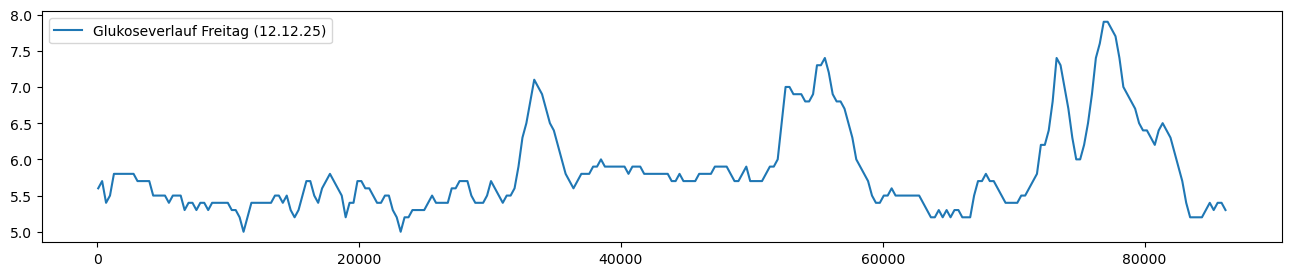

In [13]:
fig, ax = plt.subplots(1,1, figsize = (16, 3))
ax.plot(fr_2_events["delta_time_s"], fr_2_events["gluc_mmol_L"], label = "Glukoseverlauf Freitag (12.12.25)")
ax.legend()


### Datensatz für UKF bereitstellen

Als Zeitfenster für die UKF-Schätzung wird 07:01 - 12:01 Uhr gewählt. Die Auswahl erfolgt aufgrund einer Auslese in Dexcom-Clarity. Das Zeitfenster enthält ca 2h Vorlaufzeit und etwa 2h Nachlaufzeit nach dem Glukose-Impuls.

In [14]:
#Startzeitpunkt finden
starttime = "2025-12-12 07:00:00"
starttime = pd.to_datetime(starttime)
startrow = fr_2_events.loc[freitag_2["timestamp"] >= starttime].iloc[0]
startrow

timestamp           2025-12-12 07:01:22
event                               EGV
event2                              NaN
gluc_mmol_L                         5.4
kh_mg                                 0
Dauer (hh:mm:ss)                    NaN
delta_time_s                    25282.0
Name: 2150, dtype: object

In [15]:
endtime = "2025-12-12 12:00:00"
endtime = pd.to_datetime(endtime)
endrow = fr_2_events.loc[freitag_2["timestamp"] >= endtime].iloc[0]
endrow

timestamp           2025-12-12 12:01:20
event                               EGV
event2                              NaN
gluc_mmol_L                         5.8
kh_mg                                 0
Dauer (hh:mm:ss)                    NaN
delta_time_s                    43280.0
Name: 2210, dtype: object

In [16]:
#Ausschnitt erstellen mit ausschliesslich den gesuchten Daten
meal1_fr_2 = fr_2_events.copy()
meal1_fr_2 = meal1_fr_2.loc[2150:2210]
#meal1_fr_2.head(), meal1_fr_2.tail()

In [17]:
#Zeitreihe generieren mit Zeitabständen von genau 300s und Startzeitpunkt "starttime"
start = startrow["delta_time_s"]
k = len(meal1_fr_2)
time_m1_fr2 = np.arange(start, 300*k+start, 300)
#time_m1_fr2, len(time_m1_fr2), k
time_m1_fr2 = pd.DataFrame(time_m1_fr2, columns = ["time_s"])
time_m1_fr2.tail()

,time_s
56,42082.0
57,42382.0
58,42682.0
59,42982.0
60,43282.0


In [18]:
m1_fr2_ukf = pd.concat(
    [ 
        time_m1_fr2,
        meal1_fr_2[["gluc_mmol_L", "kh_mg"]].reset_index(drop = True)
    ],
    axis = 1
)
m1_fr2_ukf.head(100)

,time_s,gluc_mmol_L,kh_mg
0,25282.0,5.4,0
1,25582.0,5.5,0
2,25882.0,5.4,0
3,26182.0,5.4,0
4,26482.0,5.4,0
...,...,...,...
56,42082.0,5.8,0
57,42382.0,5.8,0
58,42682.0,5.8,0
59,42982.0,5.8,0


Überprüfen, ob Mahlzeit immer noch im Dataframe enthalten ist

In [19]:
m1_fr2_ukf.loc[m1_fr2_ukf["kh_mg"] > 0]

,time_s,gluc_mmol_L,kh_mg
22,31882.0,5.6,75000


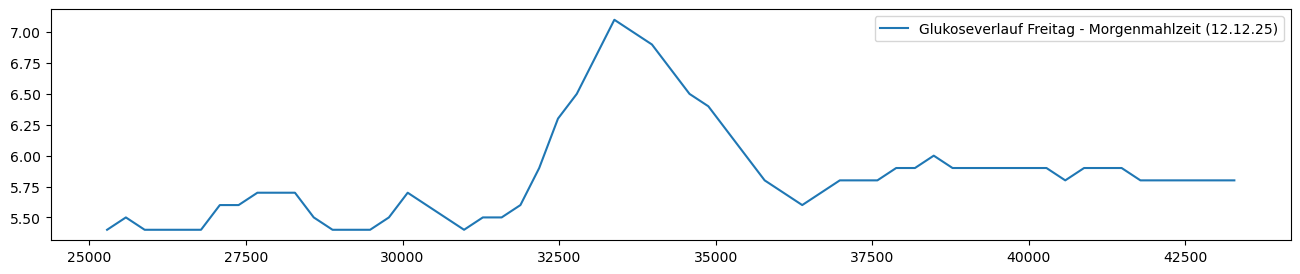

In [20]:
fig, ax = plt.subplots(1,1, figsize = (16, 3))
ax.plot(m1_fr2_ukf["time_s"], m1_fr2_ukf["gluc_mmol_L"], label = "Glukoseverlauf Freitag - Morgenmahlzeit (12.12.25)")
ax.legend()

### UKF

Iterate-Funktion

In [21]:
#Iterate Funktion mit Literaturwerten
def iterate_euler_Dt(y_in: np.ndarray, delta_t: float, inputs: tuple):
    '''Euler-Approximation der Integrationsfunktionen für EDES-Gleichungen'''
    t_current, D_meal = inputs
    y_next = np.zeros(len(y_in))
    dydt = f_odes_Dt_sim(y_in, t_current, D_meal) #arbeitet mit Literaturwerten
    y_next = y_in + dydt*delta_t
    return y_next

Parameter vorbereiten

In [22]:
#Prozessrauschen
Q_m1 = np.diag([
    1e-4,   # M_gut
    5e-3,   # G_pl
    5e-4,   # I_pl
    5e-3,   # G_i
])

In [23]:
#Kovarianzmatrix
# Schätzung von Varianzen mithilfe von Erlandsen-Paper (CV - Werte von Parametern mit ähnlicher Funktionalität) & ChatGPT
# CV = σ / μ
# var = σ^2

var_M_gut = 4 # Empfehlung ChatGPT
var_G_pl = ((0.027+0.077+0.027)/3*p.G_pl_b)**2 # CV-Werte für basale Glukose
var_I_pl = ((0.35+0.72)/2*p.I_pl_b)**2 # CV-Werte für Basales Insulin
var_G_i = var_G_pl*0.9 # Meine Annahme: Etwas kleinere Unsicherheit als Basal-Glukose

In [24]:
#Kovarianz-Matrix
covar_m1 = np.diag([
    var_M_gut, #M_gut
    var_G_pl, #G_pl
    var_I_pl, #I_pl
    0.42**2, #G_i 
])

In [25]:
"""#Kovarianz-Matrix Variante 2
covar_m1 = 0.0001*np.eye(4)"""

'#Kovarianz-Matrix Variante 2\ncovar_m1 = 0.0001*np.eye(4)'

In [26]:
G_start = p.G_pl_b
I_start = p.I_pl_b

In [27]:
y_m1 = np.array([0, #M_gut_start
            G_start, #G_pl_start
            I_start, #I_pl_start
            G_start, #G_i_start
    ]) 

In [28]:
#num_states, process_noise, initial_state, initial_covar, alpha, k, beta, iterate_function
params_m1 = {
    "num_states" : 4,
    "process_noise" : Q_m1,
    "initial_state" : y_m1,
    "initial_covar" : covar_m1,
    "alpha" : 1e-3, #Standardwert
    "k": 0, #Standardwert
    "beta" : 2.0, # Standardwert
    "iterate_function" : iterate_euler_Dt
}

UKF initialisieren

In [29]:
#UKF für Mahlzeit 1, Freitag 2 (12.12.25)
estimator_m1 = UKF(**params_m1)

step_m1 = 10 #in [s] #Predictschrittgrösse
N = len(m1_fr2_ukf)*int(300/step_m1) #Hilfszahl zum Festlegen der Länge von x_pred und time_pred
start_t = m1_fr2_ukf["time_s"].iloc[0] #Startzeitpunkt der Schätzung
ukf_data = m1_fr2_ukf.to_numpy().copy() #DataFrame in ein Array umwandeln
ukf_data[:,0] = ukf_data[:,0]-start_t #Startzeit-Verschiebung auf null setzen

x_pred_m1 = np.zeros((N+1,4)) #Array zum Speichern der UKF_Predictions
x_upd_m1 = np.zeros((len(m1_fr2_ukf),4)) #Array zum Speichern der UKF_Update-Schritte

In [30]:
pred_upd_2(ukf_data, x_pred_m1, x_upd_m1, estimator_m1, step_m1, start_t)

In [31]:
time_pred_m1 = np.arange(start_t, start_t + (N+1)*step_m1, step_m1) #Zeitreihe zum Plotten von UKF-Predictions
time_m1 = time_m1_fr2.to_numpy().copy() #Gekürzte Zeitreihe zum Plotten der CGM-Messdaten 
x_pred_m1_masked = mask_data(time_pred_m1, time_m1, x_pred_m1)
comp_m1 = ukf_data[:,1]-x_pred_m1_masked[:,3] #Differenz vorhergesagte CGM-Werte und reale CGM_werte
comp_tss = ukf_data[:,1]-np.mean(ukf_data[:,1]) #Differenz vorhergesagte CGM-Werte und Mittelwert realer Werte
name = ["G_i"]

In [32]:
comp_m1 = comp_m1[:,None]
np.shape(comp_m1), np.shape(time_m1)

((61, 1), (61, 1))

,RMSE,MAE,bias,RSS,TSS,Rsq
G_i,0.255226,0.22538,0.096711,3.973552,10.192459,0.610148


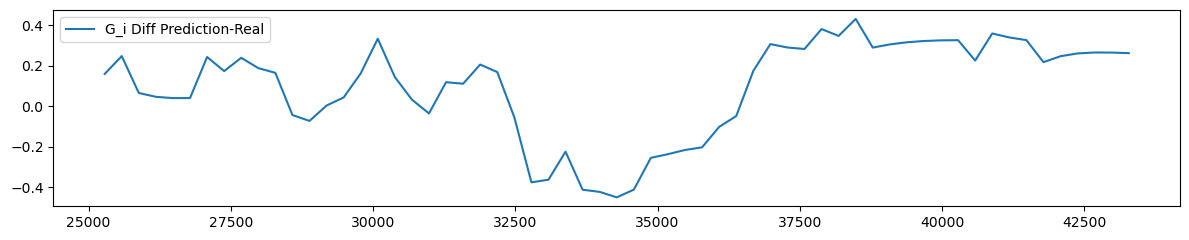

In [33]:
estimate_error_2(comp_m1, comp_tss, time_m1, name)

In [34]:
np.shape(x_upd_m1), np.shape(x_pred_m1)

((61, 4), (1831, 4))

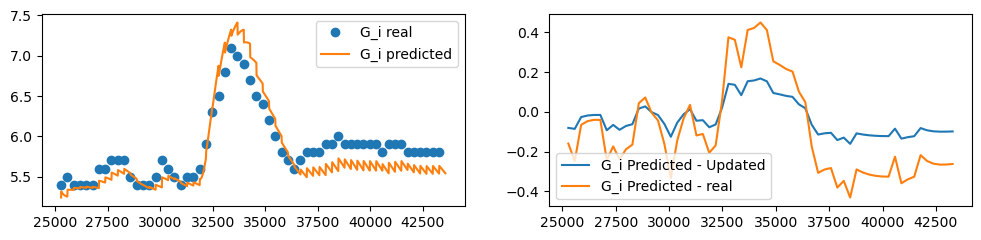

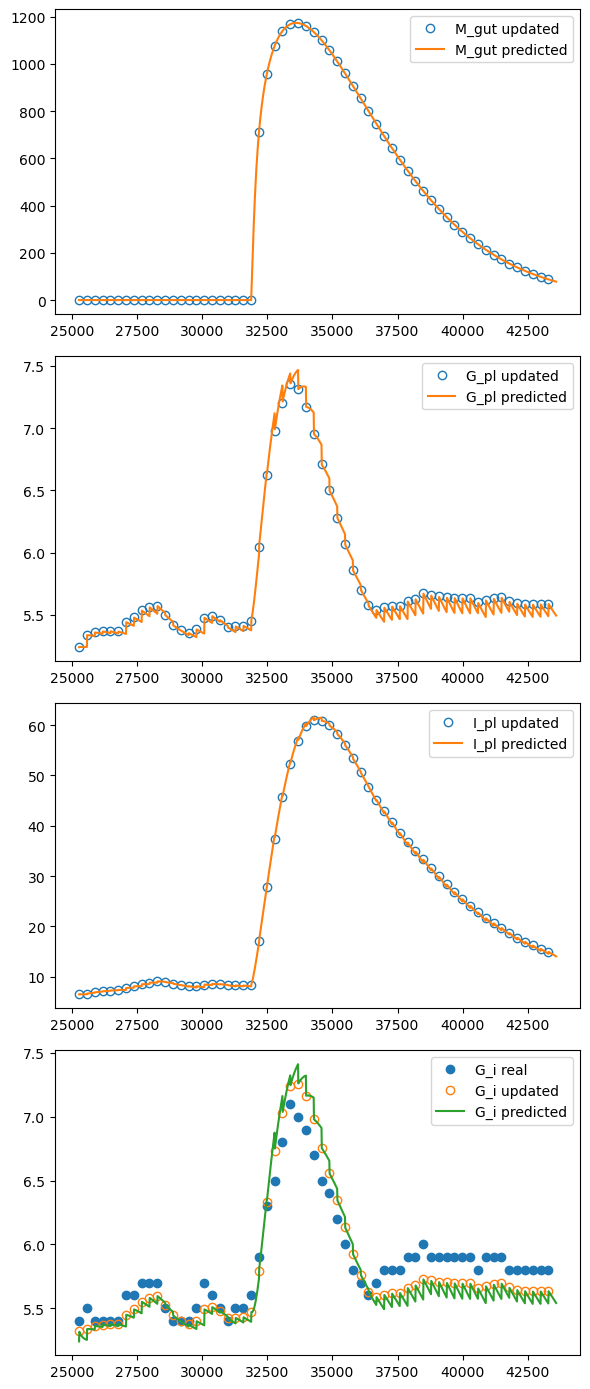

In [35]:
plot_ukf_2(ukf_data[:,1],x_upd_m1, x_pred_m1, time_m1, time_pred_m1)